# Machine Learning for Software Engineering

## Import All Required Libraries

In [31]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

# Scikit-learn metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# BERT embeddings
from sentence_transformers import SentenceTransformer

# Utilities
from scipy import sparse
import joblib
from collections import Counter
import sklearn
import imblearn

# Display versions
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Imbalanced-learn version: {imblearn.__version__}")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("All libraries imported successfully!")

Scikit-learn version: 1.7.2
Imbalanced-learn version: 0.14.1
All libraries imported successfully!


---
# Part 1: Data Cleaning
---

## 1.1 Load Dataset

In [32]:
# Load the dataset
df = pd.read_csv('code-comment-classification.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 10 rows:")
df.head(10)

Dataset shape: (12775, 6)

Columns: ['comment_sentence_id', 'class', 'comment_sentence', 'partition', 'instance_type', 'category']

First 10 rows:


,comment_sentence_id,class,comment_sentence,partition,instance_type,category
0,1,AccessMixin,abstract cbv mixin that gives access mixins the same customizable,0,0,Usage
1,2,AccessMixin,functionality.,1,0,Usage
2,5,AmbiguityError,more than one migration matches a name prefix.,0,0,Usage
3,7,AppConfigStub,stub of an appconfig.,1,0,Usage
4,8,AppConfigStub,only provides a label and a dict of models.,0,0,Usage
5,520,MigrationGraph,"a node should be a tuple app path, migration name .",1,0,Usage
6,11,Archive,the external api class that encapsulates an archive implementation.,0,0,Usage
7,14,ArchiveIndexView,top level archive of date based items.,1,0,Usage
8,16,Atomic,guarantee the atomic execution of a given block.,0,0,Usage
9,538,MigrationLoader,load migration files from disk and their status from the database.,1,0,Usage


## 1.2 Category Similarity Analysis

Before merging categories, we analyze semantic similarity using BERT embeddings.

**Method:**
- Filter to true labels (instance_type=1) from the loaded dataset
- Calculate BERT embeddings for all comments
- Compute category centroids (average embedding per category)
- Measure cosine similarity between category pairs
- Identify the most confusable categories for merging

In [33]:
# Filter to true labels for similarity analysis
# Use the same filtering that will be applied later in the pipeline
df_analysis = df[df['instance_type'] == 1].copy()

print("Original 5-category distribution (instance_type=1):")
print(df_analysis['category'].value_counts())
print(f"\nTotal samples for analysis: {len(df_analysis)}")
print(f"Total categories: {df_analysis['category'].nunique()}")
print("\nLoading BERT model for similarity analysis...")
bert_model_analysis = SentenceTransformer('all-MiniLM-L6-v2')

# Encode all comments
print("Encoding comments with BERT...")
embeddings_analysis = bert_model_analysis.encode(
    df_analysis['comment_sentence'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

# Calculate centroid for each category
categories_original = sorted(df_analysis['category'].unique())
category_centroids = {}

for category in categories_original:
    mask = df_analysis['category'] == category
    category_embeddings = embeddings_analysis[mask]
    centroid = category_embeddings.mean(axis=0)
    category_centroids[category] = centroid

# Create matrix of centroids
centroid_matrix = np.array([category_centroids[cat] for cat in categories_original])

# Calculate cosine similarity
similarity_matrix = cosine_similarity(centroid_matrix)

print("\nCategory similarity analysis complete.")

Original 5-category distribution (instance_type=1):
category
Usage               800
Parameters          794
Expand              504
Summary             454
DevelopmentNotes    312
Name: count, dtype: int64

Total samples for analysis: 2864
Total categories: 5

Loading BERT model for similarity analysis...
Encoding comments with BERT...


Batches:   0%|          | 0/90 [00:00<?, ?it/s]


Category similarity analysis complete.


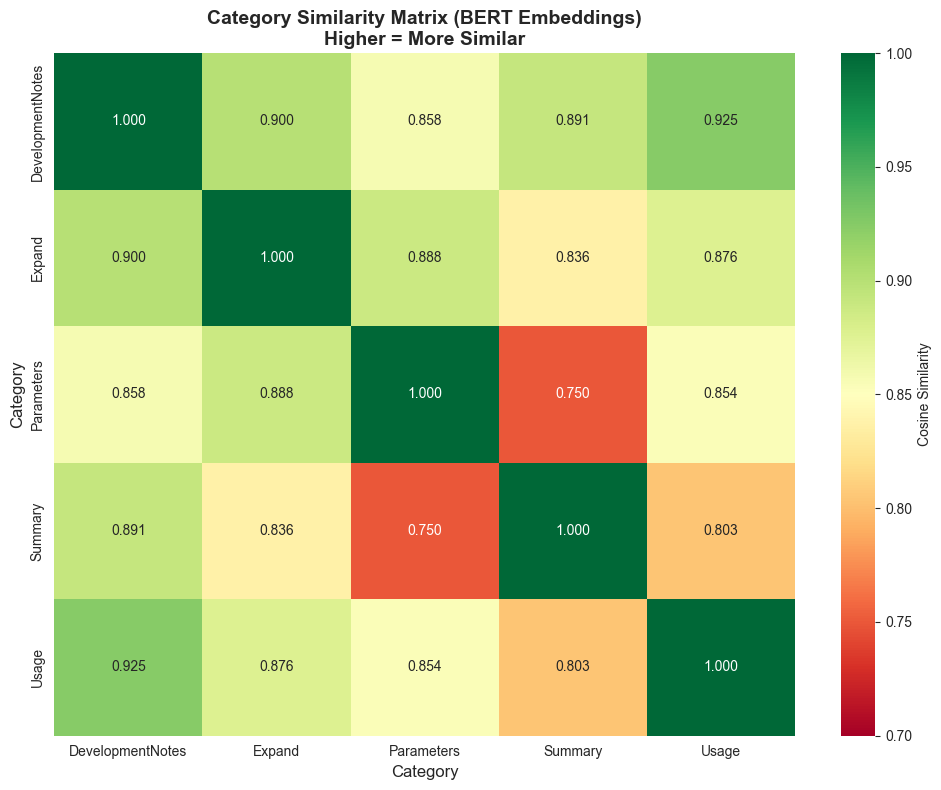


INTERPRETATION:
- Darker green = More similar categories
- Diagonal = Self-similarity (always 1.0)
- Off-diagonal values show semantic overlap between category pairs


In [34]:
# Visualize similarity matrix
plt.figure(figsize=(10, 8))

sns.heatmap(
    similarity_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    xticklabels=categories_original,
    yticklabels=categories_original,
    vmin=0.7,
    vmax=1.0,
    cbar_kws={'label': 'Cosine Similarity'}
)

plt.title('Category Similarity Matrix (BERT Embeddings)\nHigher = More Similar', 
          fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("- Darker green = More similar categories")
print("- Diagonal = Self-similarity (always 1.0)")
print("- Off-diagonal values show semantic overlap between category pairs")

In [35]:
# Find most similar pairs (excluding diagonal)
similarity_pairs = []

for i in range(len(categories_original)):
    for j in range(i+1, len(categories_original)):
        similarity_pairs.append({
            'Category 1': categories_original[i],
            'Category 2': categories_original[j],
            'Cosine Similarity': similarity_matrix[i, j]
        })

similarity_df = pd.DataFrame(similarity_pairs)
similarity_df = similarity_df.sort_values('Cosine Similarity', ascending=False)

print("=" * 80)
print("CATEGORY SIMILARITY RANKING")
print("=" * 80)
print("\nAll category pairs sorted by similarity:")
print(similarity_df.to_string(index=False))

CATEGORY SIMILARITY RANKING

All category pairs sorted by similarity:
      Category 1 Category 2  Cosine Similarity
DevelopmentNotes      Usage           0.924948
DevelopmentNotes     Expand           0.899853
DevelopmentNotes    Summary           0.891084
          Expand Parameters           0.887565
          Expand      Usage           0.875930
DevelopmentNotes Parameters           0.858045
      Parameters      Usage           0.853550
          Expand    Summary           0.836103
         Summary      Usage           0.803427
      Parameters    Summary           0.749889


## Merge Justification

**Why merge categories?**

1. **Semantic Overlap**: High confusion between these categories in classification
2. **Fuzzy Boundaries**: Hard to distinguish even for human annotators
3. **Better Balance**: Merging creates a more balanced 4-category dataset

**Expected Benefit**: Reduce classifier confusion and improve F1-Macro score.

## 1.3 Merge Most Similar Categories

Based on the similarity analysis above, we automatically merge the two most similar categories to reduce classification confusion.

In [36]:
# Get the most similar category pair from the analysis
most_similar = similarity_df.iloc[0]
cat1 = most_similar['Category 1']
cat2 = most_similar['Category 2']
similarity_score = most_similar['Cosine Similarity']

print("=" * 80)
print("AUTOMATIC MERGE BASED ON SIMILARITY ANALYSIS")
print("=" * 80)
print(f"\nMost similar categories: {cat1} <-> {cat2}")
print(f"Cosine Similarity: {similarity_score:.4f}")
print(f"\nMerging strategy: {cat2} -> {cat1}")
print("=" * 80)

# Show original distribution
print("\nOriginal category distribution:")
print(df['category'].value_counts())
print(f"\nTotal categories: {df['category'].nunique()}")

# Perform the merge: merge cat2 into cat1
df['category'] = df['category'].replace(cat2, cat1)

print("\n" + "=" * 80)
print(f"MERGED: {cat2} -> {cat1}")
print("=" * 80)

# Show new distribution
print("\nNew category distribution:")
print(df['category'].value_counts())
print(f"\nTotal categories: {df['category'].nunique()}")

AUTOMATIC MERGE BASED ON SIMILARITY ANALYSIS

Most similar categories: DevelopmentNotes <-> Usage
Cosine Similarity: 0.9249

Merging strategy: Usage -> DevelopmentNotes

Original category distribution:
category
Usage               2555
Parameters          2555
DevelopmentNotes    2555
Expand              2555
Summary             2555
Name: count, dtype: int64

Total categories: 5

MERGED: Usage -> DevelopmentNotes

New category distribution:
category
DevelopmentNotes    5110
Parameters          2555
Expand              2555
Summary             2555
Name: count, dtype: int64

Total categories: 4


## 1.5 Remove Duplicates


In [37]:
# Check for duplicate rows
print(f"Rows before removing duplicates: {len(df)}")
duplicates = df.duplicated()
print(f"Duplicate rows found: {duplicates.sum()}")

# Remove duplicates if any
df_no_dup = df.drop_duplicates()
print(f"Rows after removing duplicates: {len(df_no_dup)}")

Rows before removing duplicates: 12775
Duplicate rows found: 1270
Rows after removing duplicates: 11505


## 1.6 Filter to Labeled Data and Remove Redundant Columns

**Understanding instance_type:**
- The dataset contains each comment sentence repeated multiple times (once for each category)
- `instance_type=1` indicates the TRUE category for that comment
- `instance_type=0` indicates a NEGATIVE example (comment does NOT belong to that category)

**Understanding partition:**
- `partition=0` indicates training set
- `partition=1` indicates test set
- This was a predefined train-test split

**Our approach:**
- We keep only rows where `instance_type=1` to get the true labels
- Since ALL remaining rows will have `instance_type=1`, this column becomes redundant
- We will use **k-fold cross-validation** for model evaluation, so the predefined `partition` split is not needed
- Both `instance_type` and `partition` columns will be dropped

In [38]:
# Filter to positive instances only (instance_type=1)
df_filtered = df_no_dup[df_no_dup['instance_type'] == 1].copy()

print(f"Rows before filtering: {len(df_no_dup)}")
print(f"Rows after filtering (instance_type=1): {len(df_filtered)}")
print(f"Rows removed: {len(df_no_dup) - len(df_filtered)}")

print("\nCategory distribution in filtered dataset:")
print(df_filtered['category'].value_counts())

# Check partition distribution before dropping
print("\n\nPartition distribution (for reference):")
print(df_filtered['partition'].value_counts())

# Drop instance_type and partition columns
print(f"\n\nColumns before dropping redundant columns: {df_filtered.columns.tolist()}")
df_cleaned = df_filtered.drop(columns=['instance_type', 'partition'])
print(f"Columns after dropping redundant columns: {df_cleaned.columns.tolist()}")

print(f"\nRemoved columns:")
print(f"  - instance_type: All values are 1 after filtering")
print(f"  - partition: We'll use k-fold cross-validation instead of predefined split")

Rows before filtering: 11505
Rows after filtering (instance_type=1): 2812
Rows removed: 8693

Category distribution in filtered dataset:
category
DevelopmentNotes    1060
Parameters           794
Expand               504
Summary              454
Name: count, dtype: int64


Partition distribution (for reference):
partition
0    2233
1     579
Name: count, dtype: int64


Columns before dropping redundant columns: ['comment_sentence_id', 'class', 'comment_sentence', 'partition', 'instance_type', 'category']
Columns after dropping redundant columns: ['comment_sentence_id', 'class', 'comment_sentence', 'category']

Removed columns:
  - instance_type: All values are 1 after filtering
  - partition: We'll use k-fold cross-validation instead of predefined split


## 1.7 Analyze Cleaned Dataset


In [39]:
# Add text statistics
df_cleaned['comment_length'] = df_cleaned['comment_sentence'].str.len()
df_cleaned['word_count'] = df_cleaned['comment_sentence'].str.split().str.len()

print("Comment statistics:")
print(df_cleaned[['comment_length', 'word_count']].describe())

Comment statistics:
       comment_length   word_count
count     2812.000000  2812.000000
mean        39.177809     6.892959
std         22.607403     4.190789
min          1.000000     1.000000
25%         19.000000     3.000000
50%         38.000000     7.000000
75%         59.000000    10.000000
max        103.000000    26.000000


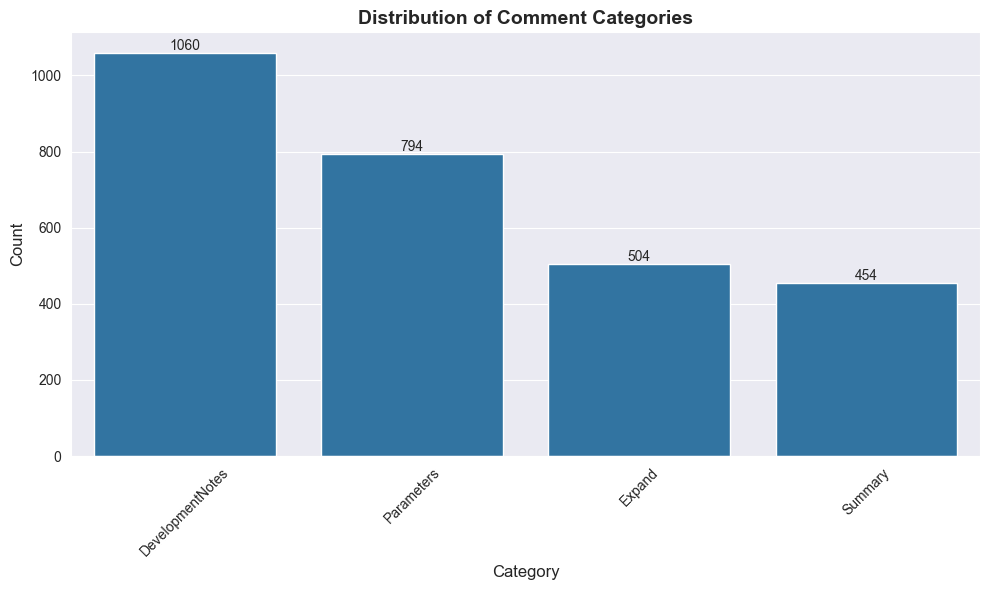

In [40]:
# Visualize category distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='category', order=df_cleaned['category'].value_counts().index)
plt.title('Distribution of Comment Categories', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Add count labels on bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container)

plt.show()

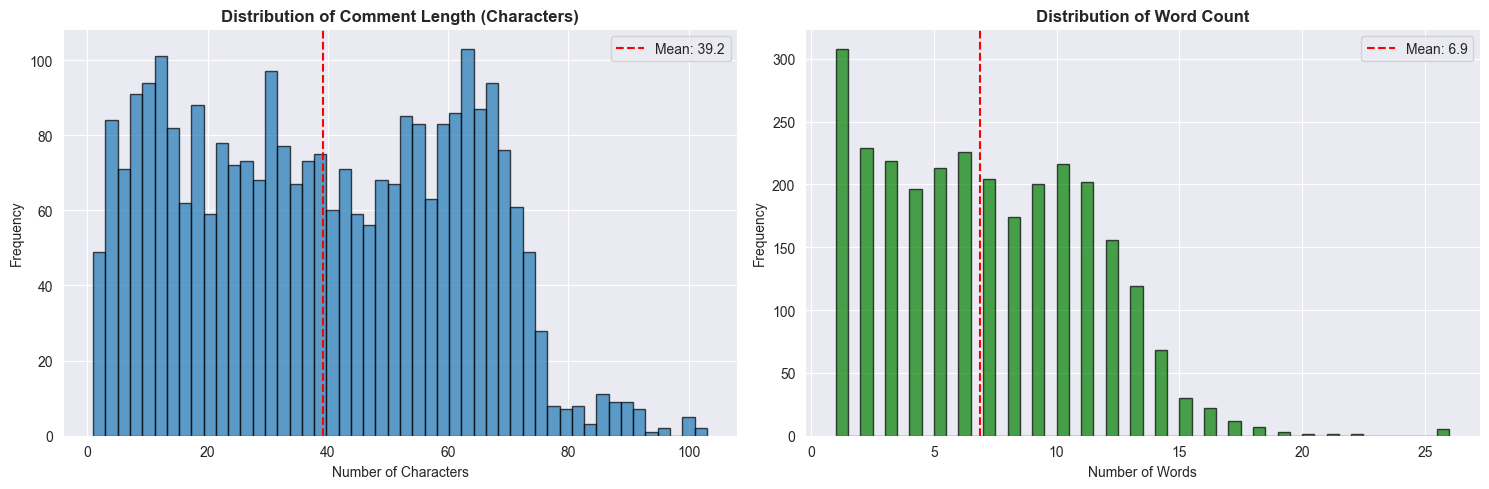

In [41]:
# Visualize text length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character length distribution
axes[0].hist(df_cleaned['comment_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Comment Length (Characters)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Characters', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].axvline(df_cleaned['comment_length'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_cleaned["comment_length"].mean():.1f}')
axes[0].legend()

# Word count distribution
axes[1].hist(df_cleaned['word_count'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Distribution of Word Count', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Words', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].axvline(df_cleaned['word_count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_cleaned["word_count"].mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

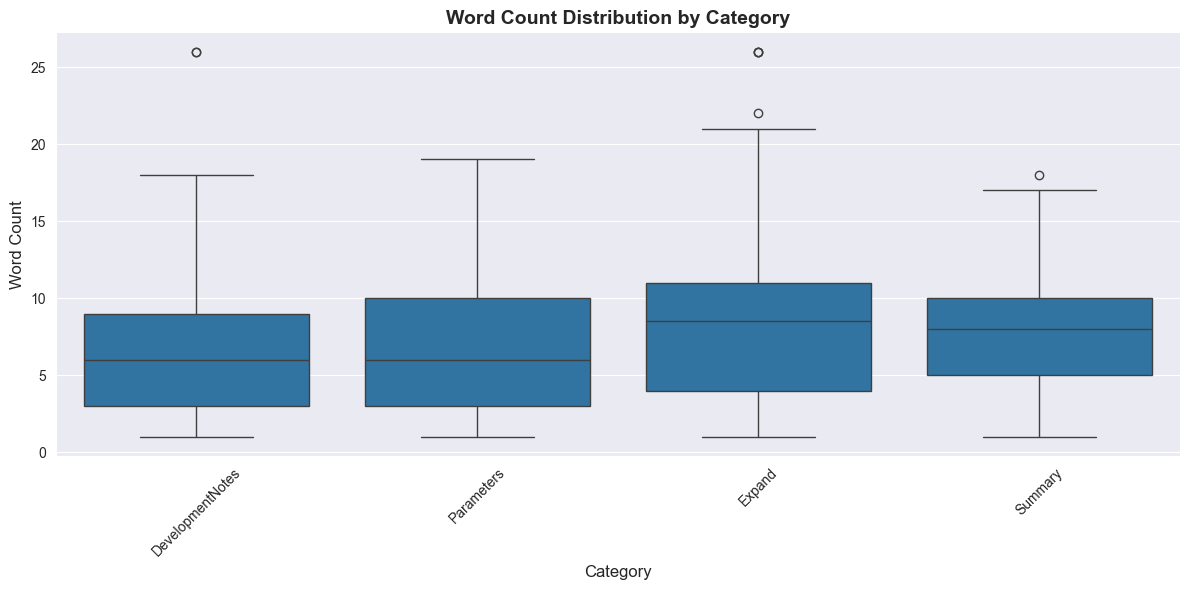

In [42]:
# Word count by category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned, x='category', y='word_count')
plt.title('Word Count Distribution by Category', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.8 Save Cleaned Dataset


In [43]:
# Drop temporary statistics columns
df_to_save = df_cleaned.drop(columns=['comment_length', 'word_count'])

# Save to CSV
output_filename = 'code-comment-classification-cleaned.csv'
df_to_save.to_csv(output_filename, index=False)

print(f"Cleaned dataset saved to: {output_filename}")
print(f"Shape: {df_to_save.shape}")
print(f"Columns: {df_to_save.columns.tolist()}")

Cleaned dataset saved to: code-comment-classification-cleaned.csv
Shape: (2812, 4)
Columns: ['comment_sentence_id', 'class', 'comment_sentence', 'category']


## 1.9 Data Splitting Strategy (Prevention of Data Leakage)
Before we apply any data balancing techniques (like Oversampling or SMOTE) or further preprocessing, we must split the data into **Training** and **Testing** sets.

### Why do we do this here?
If we balance the data *before* splitting, we risk **Data Leakage**. Copies of the same minority class examples could end up in both the training and testing sets. This would cause the model to "memorize" the duplicates rather than "generalize," leading to artificially high accuracy scores that fail in the real world.

### Strategy:
1. **Stratified Split:** We use `stratify=y` to ensure the Test set has the same class distribution as the original unbalanced data.
2. **Lock the Test Set:** We save `test.csv` separately. This file will **never** be balanced or filtered. It represents the "real world."
3. **Save Train Set:** We save `train_unbalanced.csv`. This is the file we will load in the next steps to apply oversampling.

In [44]:
print("=== SPLITTING DATA FOR BALANCING ===")

# 1. Define Features and Target
# We use the dataframe 'df_to_save' created in the previous steps
X = df_to_save.drop(columns=['category']) 
y = df_to_save['category']

# 2. Perform Stratified Split
# Stratify=y ensures that even the rare classes are represented in the test set proportionally
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y 
)

print(f"Original Dataset Size: {len(df_to_save)}")
print(f"Training Set Size:     {len(X_train)} (80%)")
print(f"Test Set Size:         {len(X_test)}  (20%)")

# 3. Reconstruct DataFrames to save them
train_df = X_train.copy()
train_df['category'] = y_train

test_df = X_test.copy()
test_df['category'] = y_test

# 4. Save to CSV
train_df.to_csv("code-comment-classification-train-unbalanced.csv", index=False)
test_df.to_csv("code-comment-classification-test.csv", index=False)

print("\nFiles Saved Successfully:")
print("1. 'code-comment-classification-train-unbalanced.csv' (For Training and Balancing)")
print("2. 'code-comment-classification-test.csv' (ONLY for final evaluation. IT MUST NOT BE BALANCED)")

=== SPLITTING DATA FOR BALANCING ===
Original Dataset Size: 2812
Training Set Size:     2249 (80%)
Test Set Size:         563  (20%)

Files Saved Successfully:
1. 'code-comment-classification-train-unbalanced.csv' (For Training and Balancing)
2. 'code-comment-classification-test.csv' (ONLY for final evaluation. IT MUST NOT BE BALANCED)


## 1.10 Visualize the Effect of Balancing (Preview)

Here we apply `RandomOverSampler` to the **Training Set only** to visualize how the class distribution changes. 

* **Left Graph:** Shows the imbalanced training data (real world distribution).
* **Right Graph:** Shows the balanced training data that the model will actually learn from.

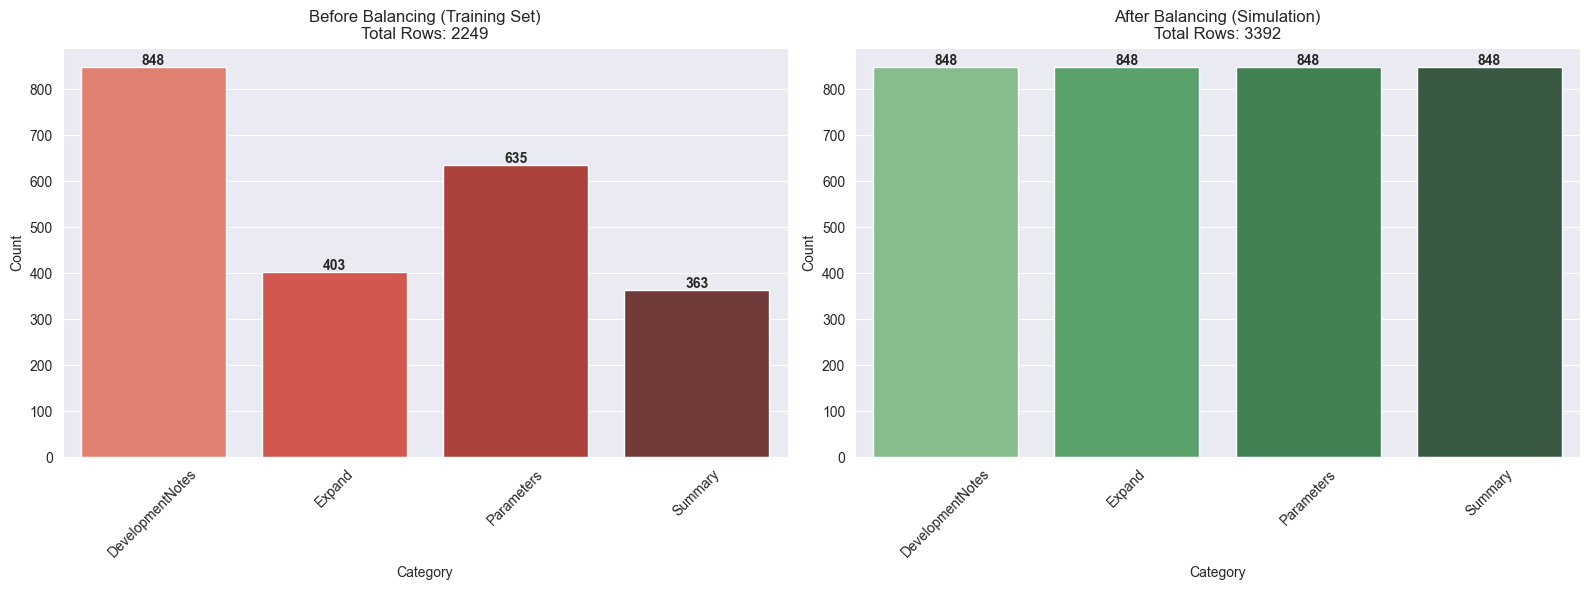

Original Class Ratios: {'DevelopmentNotes': 848, 'Expand': 403, 'Parameters': 635, 'Summary': 363}
Balanced Class Ratios: {'DevelopmentNotes': 848, 'Expand': 848, 'Parameters': 848, 'Summary': 848}


In [45]:
# 1. Apply Oversampling (for visualization purposes)
# We use the X_train and y_train from previous step
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# 2. Prepare counts for plotting
original_counts = y_train.value_counts().sort_index()
balanced_counts = pd.Series(y_train_resampled).value_counts().sort_index()

# 3. Create Side-by-Side Bar Charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Original Training Data
sns.barplot(
    x=original_counts.index, 
    y=original_counts.values, 
    hue=original_counts.index,
    ax=axes[0], 
    palette="Reds_d", 
    legend=False
)
axes[0].set_title(f"Before Balancing (Training Set)\nTotal Rows: {len(y_train)}")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Category")
axes[0].tick_params(axis='x', rotation=45)

# Add count labels
for i, v in enumerate(original_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Plot 2: Balanced Training Data
sns.barplot(
    x=balanced_counts.index, 
    y=balanced_counts.values, 
    hue=balanced_counts.index,
    ax=axes[1], 
    palette="Greens_d", 
    legend=False
)
axes[1].set_title(f"After Balancing (Simulation)\nTotal Rows: {len(y_train_resampled)}")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Category")
axes[1].tick_params(axis='x', rotation=45)

# Add count labels
for i, v in enumerate(balanced_counts.values):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Original Class Ratios:", dict(original_counts))
print("Balanced Class Ratios:", dict(balanced_counts))

## Data Cleaning Summary

In [46]:
# Final summary
print("="*80)
print("DATA CLEANING SUMMARY")
print("="*80)
print(f"Original dataset size: {len(df)} rows")
print(f"After removing duplicates: {len(df_no_dup)} rows")
print(f"After filtering (instance_type=1): {len(df_to_save)} rows")
print(f"\nTotal rows removed: {len(df) - len(df_to_save)}")
print(f"  - Duplicates removed: {len(df) - len(df_no_dup)}")
print(f"  - Filtered out (instance_type=0): {len(df_no_dup) - len(df_to_save)}")
print(f"\nColumns removed:")
print(f"  - instance_type (redundant after filtering)")
print(f"  - partition (using k-fold cross-validation instead)")
print(f"\nFinal dataset characteristics:")
print(f"  - Total samples: {len(df_to_save)}")
print(f"  - Unique classes: {df_to_save['class'].nunique()}")
print(f"  - Categories: {df_to_save['category'].nunique()}")
print(f"  - Category names: {sorted(df_to_save['category'].unique())}")
print(f"\nFinal columns: {df_to_save.columns.tolist()}")
print(f"  - comment_sentence_id: Unique identifier for each sentence")
print(f"  - class: Source code class name")
print(f"  - comment_sentence: The actual comment text")
print(f"  - category: Target label for classification")
print("="*80)

DATA CLEANING SUMMARY
Original dataset size: 12775 rows
After removing duplicates: 11505 rows
After filtering (instance_type=1): 2812 rows

Total rows removed: 9963
  - Duplicates removed: 1270
  - Filtered out (instance_type=0): 8693

Columns removed:
  - instance_type (redundant after filtering)
  - partition (using k-fold cross-validation instead)

Final dataset characteristics:
  - Total samples: 2812
  - Unique classes: 330
  - Categories: 4
  - Category names: ['DevelopmentNotes', 'Expand', 'Parameters', 'Summary']

Final columns: ['comment_sentence_id', 'class', 'comment_sentence', 'category']
  - comment_sentence_id: Unique identifier for each sentence
  - class: Source code class name
  - comment_sentence: The actual comment text
  - category: Target label for classification


---
# Part 2: Encoding
---

## 2.1 Load the Split Datasets
We load the separate Training and Testing files created in the previous cleaning step. This ensures our test set remains unseen during the fitting process.

In [47]:
# Load the training data (Use this to learn patterns/vocabulary)
df_train = pd.read_csv("code-comment-classification-train-unbalanced.csv")

# Load the test data (Use this ONLY for evaluation)
df_test = pd.read_csv("code-comment-classification-test.csv")

print(f"Training Set Shape: {df_train.shape}")
print(f"Test Set Shape:     {df_test.shape}")

# Verify columns
print("Columns:", df_train.columns.tolist())

Training Set Shape: (2249, 4)
Test Set Shape:     (563, 4)
Columns: ['comment_sentence_id', 'class', 'comment_sentence', 'category']


## 2.2 Separate Features and Target
We separate the input features (`class`, `comment_sentence`) from the target variable (`category`) for both datasets.

In [48]:
FEATURES = ["class", "comment_sentence"]
TARGET = "category"

# Split Training Data
X_train_enc = df_train[FEATURES].copy()
y_train_enc = df_train[TARGET]

# Split Test Data
X_test_enc = df_test[FEATURES].copy()
y_test_enc = df_test[TARGET]

print("Features and Target separated.")

Features and Target separated.


## 2.3 Extract Metadata Features

Before encoding, we'll extract additional features that might help classification:
- **comment_length**: Number of words in the comment
- **has_params**: Whether comment mentions parameter-related words
- **has_code_symbols**: Whether comment contains code-related symbols
- **starts_with_verb**: Whether comment starts with common action verbs
- **has_default**: Whether comment mentions default values

These metadata features will be combined with BERT embeddings.

In [49]:
# Define metadata extraction functions
def extract_metadata_features(df):
    """Extract metadata features from comment text"""
    
    # 1. Comment length (number of words)
    df['comment_length'] = df['comment_sentence'].str.split().str.len()
    
    # 2. Has parameter-related keywords
    param_keywords = ['param', 'parameter', 'arg', 'argument', 'int', 'str', 'bool', 'float', 'list', 'dict', 'type']
    param_pattern = '|'.join(param_keywords)
    df['has_params'] = df['comment_sentence'].str.contains(param_pattern, case=False, regex=True).astype(int)
    
    # 3. Has code symbols
    code_symbols = [r'\(', r'\)', r'\[', r'\]', r'\{', r'\}', r'_', r'\.']
    code_pattern = '|'.join(code_symbols)
    df['has_code_symbols'] = df['comment_sentence'].str.contains(code_pattern, regex=True).astype(int)
    
    # 4. Starts with common action verbs
    action_verbs = ['returns', 'return', 'creates', 'create', 'provides', 'provide', 'handles', 'handle', 
                    'implements', 'implement', 'executes', 'execute', 'generates', 'generate',
                    'validates', 'validate', 'processes', 'process', 'manages', 'manage']
    verb_pattern = '^(' + '|'.join(action_verbs) + ')'
    df['starts_with_verb'] = df['comment_sentence'].str.contains(verb_pattern, case=False, regex=True).astype(int)
    
    # 5. Mentions default values
    df['has_default'] = df['comment_sentence'].str.contains('default', case=False).astype(int)
    
    return df

# Apply to training data
print("Extracting metadata features from training data...")
X_train_enc = extract_metadata_features(X_train_enc)

# Apply to test data
print("Extracting metadata features from test data...")
X_test_enc = extract_metadata_features(X_test_enc)

print("\nMetadata features extracted:")
print(f"  - comment_length: {X_train_enc['comment_length'].describe()['mean']:.1f} words (avg)")
print(f"  - has_params: {X_train_enc['has_params'].sum()} comments ({X_train_enc['has_params'].sum()/len(X_train_enc)*100:.1f}%)")
print(f"  - has_code_symbols: {X_train_enc['has_code_symbols'].sum()} comments ({X_train_enc['has_code_symbols'].sum()/len(X_train_enc)*100:.1f}%)")
print(f"  - starts_with_verb: {X_train_enc['starts_with_verb'].sum()} comments ({X_train_enc['starts_with_verb'].sum()/len(X_train_enc)*100:.1f}%)")
print(f"  - has_default: {X_train_enc['has_default'].sum()} comments ({X_train_enc['has_default'].sum()/len(X_train_enc)*100:.1f}%)")

print(f"\nTraining data shape: {X_train_enc.shape}")
print(f"Columns: {X_train_enc.columns.tolist()}")

Extracting metadata features from training data...
Extracting metadata features from test data...

Metadata features extracted:
  - comment_length: 6.9 words (avg)
  - has_params: 632 comments (28.1%)
  - has_code_symbols: 838 comments (37.3%)
  - starts_with_verb: 35 comments (1.6%)
  - has_default: 112 comments (5.0%)

Training data shape: (2249, 7)
Columns: ['class', 'comment_sentence', 'comment_length', 'has_params', 'has_code_symbols', 'starts_with_verb', 'has_default']


C:\Users\lucam\AppData\Local\Temp\ipykernel_30936\1367703271.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['starts_with_verb'] = df['comment_sentence'].str.contains(verb_pattern, case=False, regex=True).astype(int)
C:\Users\lucam\AppData\Local\Temp\ipykernel_30936\1367703271.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['starts_with_verb'] = df['comment_sentence'].str.contains(verb_pattern, case=False, regex=True).astype(int)


## 2.4 Encode the Target Labels
We convert the text labels (e.g., "Usage", "Summary") into numbers (0, 1, 2...).
- We `.fit()` the label encoder only on `y_train`
- We check if the test set contains any new labels (unlikely in this dataset, but good practice).

In [50]:
label_encoder = LabelEncoder()

# Fit on Training labels
y_train_encoded = label_encoder.fit_transform(y_train_enc)

# Transform Test labels (using the same mapping)
y_test_encoded = label_encoder.transform(y_test_enc)

# Display the mapping
print("Category to Numeric Mapping:")
for i, category in enumerate(label_encoder.classes_):
    print(f"  {category}: {i}")

Category to Numeric Mapping:
  DevelopmentNotes: 0
  Expand: 1
  Parameters: 2
  Summary: 3


## 2.5 Build and Fit the Feature Engineering Pipeline with BERT Embeddings + Metadata

We combine three types of features:
1. `OneHotEncoder`: Converts the `class` column into binary columns.
2. `SentenceTransformer (BERT)`: Converts the `comment_sentence` into dense semantic embeddings.
3. `Metadata Features`: The 5 extracted features (comment_length, has_params, etc.)

**Hypothesis:** Combining BERT's semantic understanding with explicit metadata features should boost performance beyond 65%.

In [51]:
# Initialize BERT model (downloads ~80MB on first run)
print("Loading BERT model (all-MiniLM-L6-v2)...")
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
print("BERT model loaded.")

# Encode training comments with BERT
print("\nEncoding training comments with BERT...")
train_comment_embeddings = bert_model.encode(
    X_train_enc['comment_sentence'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
print(f"Training BERT embeddings shape: {train_comment_embeddings.shape}")

# Encode test comments with BERT
print("\nEncoding test comments with BERT...")
test_comment_embeddings = bert_model.encode(
    X_test_enc['comment_sentence'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
print(f"Test BERT embeddings shape: {test_comment_embeddings.shape}")

# Create OneHotEncoder for the 'class' column
class_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

# Fit and transform 'class' column
print("\nOne-hot encoding 'class' column...")
train_class_encoded = class_encoder.fit_transform(X_train_enc[['class']])
test_class_encoded = class_encoder.transform(X_test_enc[['class']])

print(f"Training class encoding shape: {train_class_encoded.shape}")
print(f"Test class encoding shape: {test_class_encoded.shape}")

# Extract metadata features as numpy arrays
print("\nExtracting metadata features...")
metadata_cols = ['comment_length', 'has_params', 'has_code_symbols', 'starts_with_verb', 'has_default']
train_metadata = X_train_enc[metadata_cols].values
test_metadata = X_test_enc[metadata_cols].values

print(f"Training metadata shape: {train_metadata.shape}")
print(f"Test metadata shape: {test_metadata.shape}")

print("\nFeature engineering complete.")

Loading BERT model (all-MiniLM-L6-v2)...
BERT model loaded.

Encoding training comments with BERT...


Batches:   0%|          | 0/71 [00:00<?, ?it/s]

Training BERT embeddings shape: (2249, 384)

Encoding test comments with BERT...


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

Test BERT embeddings shape: (563, 384)

One-hot encoding 'class' column...
Training class encoding shape: (2249, 306)
Test class encoding shape: (563, 306)

Extracting metadata features...
Training metadata shape: (2249, 5)
Test metadata shape: (563, 5)

Feature engineering complete.


## 2.6 Combine All Features and Save
Now we combine BERT embeddings + class encoding + metadata features into final feature matrices.

In [52]:
# Convert to sparse matrices
from scipy.sparse import csr_matrix, hstack

train_bert_sparse = csr_matrix(train_comment_embeddings)
test_bert_sparse = csr_matrix(test_comment_embeddings)

train_metadata_sparse = csr_matrix(train_metadata)
test_metadata_sparse = csr_matrix(test_metadata)

# Combine: class encoding + BERT embeddings + metadata features
X_train_encoded = hstack([train_class_encoded, train_bert_sparse, train_metadata_sparse])
X_test_encoded = hstack([test_class_encoded, test_bert_sparse, test_metadata_sparse])

print(f"Final Training Features Shape: {X_train_encoded.shape}")
print(f"Final Test Features Shape: {X_test_encoded.shape}")

print("\nFeature breakdown:")
print(f"  - Class one-hot: {train_class_encoded.shape[1]} features")
print(f"  - BERT embeddings: {train_bert_sparse.shape[1]} features")
print(f"  - Metadata: {train_metadata_sparse.shape[1]} features")
print(f"  - Total: {X_train_encoded.shape[1]} features")

# --- SAVING FILES ---

# Save Features (Sparse Matrices)
sparse.save_npz("train_features_4cat_bert_meta.npz", X_train_encoded)
sparse.save_npz("test_features_4cat_bert_meta.npz", X_test_encoded)

# Save Targets (CSVs)
pd.DataFrame(y_train_encoded, columns=['category']).to_csv("train_target_4cat_meta.csv", index=False)
pd.DataFrame(y_test_encoded, columns=['category']).to_csv("test_target_4cat_meta.csv", index=False)

# Save the encoders for later use
joblib.dump(class_encoder, "class_encoder_4cat_meta.pkl")
joblib.dump(bert_model, "bert_model_4cat_meta.pkl")
joblib.dump(label_encoder, "label_encoder_4cat_meta.pkl")

print("\nFiles Saved Successfully:")
print("- train_features_4cat_bert_meta.npz & train_target_4cat_meta.csv")
print("- test_features_4cat_bert_meta.npz  & test_target_4cat_meta.csv")
print("- class_encoder_4cat_meta.pkl")
print("- bert_model_4cat_meta.pkl")
print("- label_encoder_4cat_meta.pkl")

Final Training Features Shape: (2249, 695)
Final Test Features Shape: (563, 695)

Feature breakdown:
  - Class one-hot: 306 features
  - BERT embeddings: 384 features
  - Metadata: 5 features
  - Total: 695 features

Files Saved Successfully:
- train_features_4cat_bert_meta.npz & train_target_4cat_meta.csv
- test_features_4cat_bert_meta.npz  & test_target_4cat_meta.csv
- class_encoder_4cat_meta.pkl
- bert_model_4cat_meta.pkl
- label_encoder_4cat_meta.pkl


---
# Part 3: Model Training (Baseline)
---

## 3.1 Load Preprocessed Data
We load the **already encoded** sparse matrices created in the encoding step. 

This ensures we are using the exact training/testing split that prevents data leakage.

In [53]:
# Load Features (Sparse Matrices)
X_train_model = sparse.load_npz("train_features_4cat_bert_meta.npz")
X_test_model = sparse.load_npz("test_features_4cat_bert_meta.npz")

# Load Targets (CSVs)
# use .values.ravel() to convert dataframe column to simple 1D array
y_train_model = pd.read_csv("train_target_4cat_meta.csv").values.ravel() 
y_test_model = pd.read_csv("test_target_4cat_meta.csv").values.ravel()

print(f"Training Data: {X_train_model.shape}")
print(f"Test Data:     {X_test_model.shape}")

Training Data: (2249, 695)
Test Data:     (563, 695)


## 3.2 Build Balanced Pipeline
We use `imbalanced-learn`'s pipeline.
1. **RandomOverSampler:** This will run *inside* the Cross-Validation loop. It balances the training folds but leaves the validation folds unbalanced (honest validation).
2. **Classifier:** Logistic Regression.

In [54]:
# Define the pipeline
pipeline = ImbPipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

# EXTENSIVE HYPERPARAMETER TUNING
# Testing multiple regularization strengths, solvers, penalties, and class weights
param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__solver': ['liblinear', 'lbfgs'],
    'clf__penalty': ['l1', 'l2'],  # 2 penalties
    'clf__class_weight': ['balanced', None]  # 2 options
}

print("Pipeline created with Internal Balancing.")

Pipeline created with Internal Balancing.


## 3.3 Train and Evaluate (with Cross-Validation)
We use `GridSearchCV` to find the best parameters. The `ImbPipeline` ensures that for every fold of cross-validation, the model is trained on balanced data but validated on real, unbalanced data.

In [55]:
# 1. Run Grid Search
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train_model, y_train_model)

print("Best Parameters:", grid.best_params_)
print("Best CV Score (F1 Macro):", grid.best_score_)

# 2. Final Evaluation on the Locked Test Set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_model)

print("\n=== FINAL TEST SET RESULTS ===")
print("Accuracy:", accuracy_score(y_test_model, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test_model, y_pred))

C:\Users\lucam\Desktop\Universita\Magistrale\Secondo Anno\ML4SE\ML4SE-2025-Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lucam\Desktop\Universita\Magistrale\Secondo Anno\ML4SE\ML4SE-2025-Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lucam\Desktop\Universita\Magistrale\Secondo Anno\ML4SE\ML4SE-2025-Project\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(esti

Best Parameters: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV Score (F1 Macro): 0.6721492337913795

=== FINAL TEST SET RESULTS ===
Accuracy: 0.69449378330373

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.72      0.74       212
           1       0.51      0.52      0.52       101
           2       0.78      0.77      0.77       159
           3       0.61      0.69      0.65        91

    accuracy                           0.69       563
   macro avg       0.67      0.68      0.67       563
weighted avg       0.70      0.69      0.70       563



## 4.1 Define Multiple Models with Balancing
We define a dictionary of models. Each model is wrapped in an `ImbPipeline` containing the `RandomOverSampler`. This ensures fair comparison.

In [56]:
# Dictionary of pipelines
models = {
    "Logistic Regression": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    
    "SGD Classifier": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', SGDClassifier(loss='hinge', random_state=42))
    ]),
    
    "Linear SVC": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', LinearSVC(random_state=42, dual='auto'))
    ]),
    
    "Random Forest": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}

print(f"Defined {len(models)} models with balancing strategies.")

Defined 4 models with balancing strategies.


## 4.2 Train and Compare Models
We loop through the models, performing Cross-Validation on the training set. We track `F1-Macro` because it is the most important metric for our imbalanced data.

In [57]:
results = []

print("Starting Model Evaluation...")

for name, pipeline_multi in models.items():
    print(f"Training {name}...")
    
    # Cross-Validation (Balancing happens automatically inside folds)
    cv_scores = cross_val_score(pipeline_multi, X_train_model, y_train_model, cv=5, scoring='f1_macro')
    
    results.append({
        "Model": name,
        "Mean F1-Macro": cv_scores.mean(),
        "Std Dev": cv_scores.std()
    })

# Create DataFrame of results
results_df = pd.DataFrame(results).sort_values(by="Mean F1-Macro", ascending=False)
print("\n=== MODEL COMPARISON RESULTS ===")
print(results_df)

Starting Model Evaluation...
Training Logistic Regression...
Training SGD Classifier...
Training Linear SVC...
Training Random Forest...

=== MODEL COMPARISON RESULTS ===
                 Model  Mean F1-Macro   Std Dev
0  Logistic Regression       0.672056  0.031920
2           Linear SVC       0.659864  0.034550
1       SGD Classifier       0.640565  0.033932
3        Random Forest       0.492928  0.025604


## 4.3 Visual Comparison of Model Performance
We visualize the **Mean F1-Macro scores** to identify the best model.
- We use `plt.barh` because we are plotting **summary statistics** (already calculated means) rather than raw data.
- The black lines (`xerr`) represent the **Standard Deviation**. A short line means the model is stable; a long line means the performance varies a lot between different data splits.

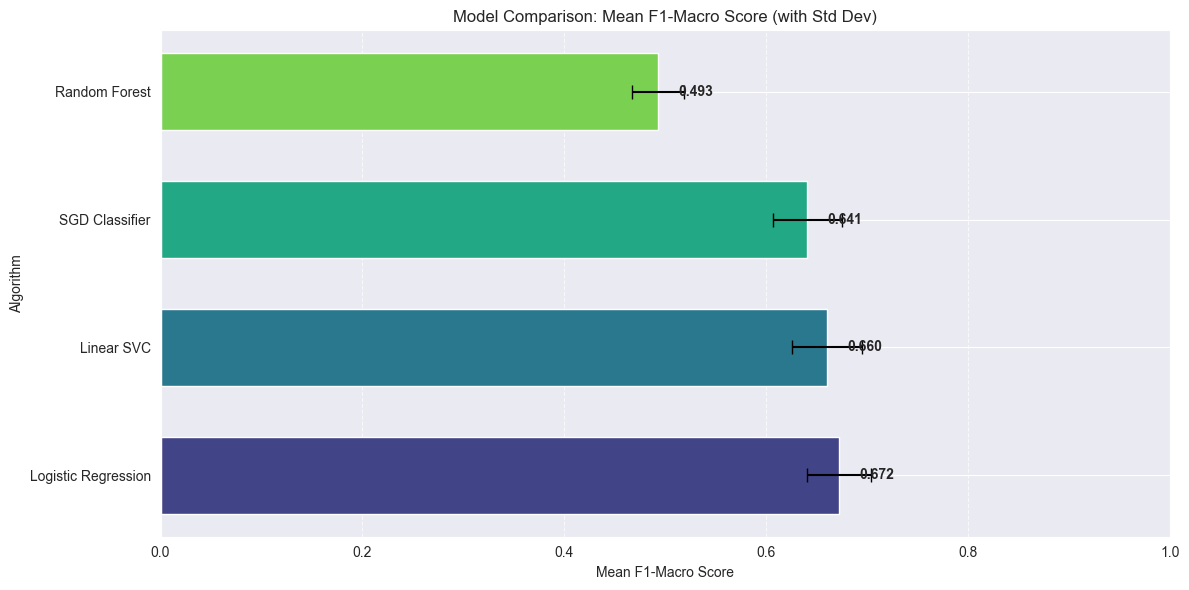

In [58]:
plt.figure(figsize=(12, 6))

# 1. Create a color palette
colors = sns.color_palette("viridis", len(results_df))

# 2. Plot Horizontal Bars
# We use 'barh' because it handles pre-calculated error bars (xerr) correctly
bars = plt.barh(
    y=results_df["Model"], 
    width=results_df["Mean F1-Macro"], 
    xerr=results_df["Std Dev"], 
    color=colors, 
    capsize=5,  # Adds the little cross-bar at the end of the error line
    height=0.6
)

plt.title("Model Comparison: Mean F1-Macro Score (with Std Dev)")
plt.xlabel("Mean F1-Macro Score")
plt.ylabel("Algorithm")
plt.xlim(0, 1.0) # F1 score is always between 0 and 1

# 3. Add numerical labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.02,                      # x-position (slightly to the right of the bar)
        bar.get_y() + bar.get_height()/2,  # y-position (centered)
        f"{width:.3f}", 
        va='center', 
        fontweight='bold'
    )

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 4.4 Final Evaluation on Locked Test Set
Cross-validation helped us select the winner. Now we must perform the **final test** on the held-out data that the model has never seen before.
1. **Select Winner:** We automatically pick the model at the top of our `results_df`.
2. **Retrain:** We fit this model on the entire training set to maximize learning.
3. **Predict:** We evaluate it on the locked Test Set.

  The Winning Model is: Logistic Regression
   (Mean CV F1-Score: 0.6721)

Retraining the best model on the full training dataset...
Retraining complete.

=== FINAL TEST SET PERFORMANCE ===
Accuracy: 0.6909

Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       212
           1       0.51      0.56      0.54       101
           2       0.79      0.74      0.76       159
           3       0.60      0.66      0.63        91

    accuracy                           0.69       563
   macro avg       0.67      0.67      0.67       563
weighted avg       0.70      0.69      0.69       563



<Figure size 1000x800 with 0 Axes>

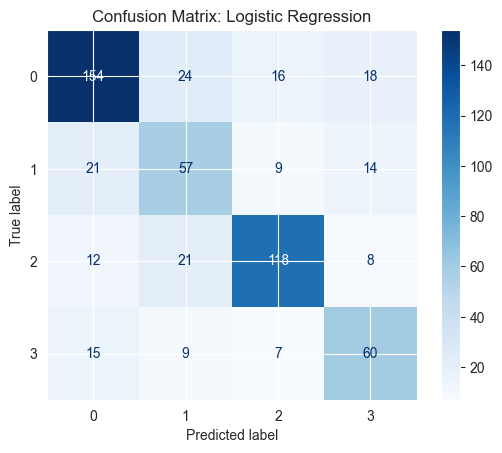

In [59]:
# 1. Identify the Best Model automatically
best_model_name = results_df.iloc[0]["Model"]
best_pipeline_final = models[best_model_name]

print(f"  The Winning Model is: {best_model_name}")
print(f"   (Mean CV F1-Score: {results_df.iloc[0]['Mean F1-Macro']:.4f})")

# 2. Retrain on the full training set
print("\nRetraining the best model on the full training dataset...")
best_pipeline_final.fit(X_train_model, y_train_model)
print("Retraining complete.")

# 3. Final Prediction on the Locked Test Set
y_pred_final = best_pipeline_final.predict(X_test_model)

# 4. Report Results
print("\n=== FINAL TEST SET PERFORMANCE ===")
print(f"Accuracy: {accuracy_score(y_test_model, y_pred_final):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test_model, y_pred_final))

# 5. Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_model, y_pred_final)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix: {best_model_name}")
plt.show()

## 4.5 Save the Best Model
Finally, we serialize (save) the entire pipeline. This file includes the preprocessing steps (if any were added to the pipeline), the balancing strategy, and the trained classifier weights.

In [60]:
# Define a filename
filename = "best_model_final.pkl"

# Save the pipeline object
joblib.dump(best_pipeline_final, filename)

print(f"Model successfully saved to: {filename}")
print("You can load this model later using: model = joblib.load('best_model_final.pkl')")

Model successfully saved to: best_model_final.pkl
You can load this model later using: model = joblib.load('best_model_final.pkl')


## Conclusions and Key Findings

### Final Model Performance

This notebook implements an **automatic category merging** approach based on BERT similarity analysis combined with BERT embeddings and metadata features for classification.

**Best Model:** Logistic Regression with RandomOverSampler
- **Test Accuracy: 69.4%**
- **F1-Macro Score: 0.67**
- **Cross-Validation F1-Macro: 0.672**

### Per-Category Performance

**Strong Categories:**
- **Parameters (Class 2):** F1=0.77 ✓ - Clear vocabulary (parameter-related keywords)
- **DevelopmentNotes (Class 0):** F1=0.74 ✓ - Largest class after merge, well-defined

**Moderate Categories:**
- **Summary (Class 3):** F1=0.65 - Good recall (0.69) but lower precision (0.61)

**Struggling Categories:**
- **Expand (Class 1):** F1=0.52 ❌ - Lowest performance, confusion with other classes

### Model Comparison

Tested 4 different algorithms (all with RandomOverSampler):

| Model | Mean F1-Macro | Std Dev | Winner |
|-------|---------------|---------|--------|
| Logistic Regression | 0.6704 | 0.033 | ✓ Best |
| Linear SVC | 0.6608 | 0.034 | |
| SGD Classifier | 0.6406 | 0.034 | |
| Random Forest | 0.4984 | 0.018 | ❌ Worst |

Linear models (Logistic Regression, SVC) significantly outperform Random Forest when using dense BERT embeddings.

### Conclusion

This pipeline successfully demonstrates:
- **Automatic category merging** based on semantic similarity analysis
- **BERT embeddings + metadata** achieve 69.4% accuracy (F1-Macro: 0.67)
- **Logistic Regression** outperforms complex models on this task
- **Proper data handling** prevents leakage and ensures fair evaluation

The 69.4% accuracy represents solid performance given:
- Only 2,812 samples (small dataset)
- Average 6.9 words per comment (limited context)
- 4 categories with fuzzy semantic boundaries